In [1]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, \
recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

import numpy as np

import matplotlib.pylab as plt

from scipy.sparse import vstack, dok_matrix, csr_matrix, lil_matrix

import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
physicians = pd.read_csv('../physicians.csv')
# physicians.info()

procedures = pd.read_csv('../procedures.csv')
# procedures.info()

In [3]:
# split phsician data into unknown and known

# Get unknown index
_choose = ['Unknown' in specialty for specialty in physicians['specialty']]
phys_unknown = physicians[_choose]
phys_known = physicians[[not ii for ii in _choose]]

# phys_unknown.info()

In [4]:
class FeatureExtractorBase(BaseEstimator, TransformerMixin):
    _procedure_words = list(pd.read_csv('procedure_words_list.csv')['word'].values)
    _procedure_codes = list(pd.read_csv('procedure_codes_list.csv')['code'].values)
    _all_procedures_df = procedures
    
    def __init__(self, feature_include_words, feature_include_codes):
        
        self._feature_list = []
        
        if feature_include_codes:
            self._feature_list += self._procedure_codes
        
        if feature_include_words:
            self._feature_list += self._procedure_words
        
        self._num_features = len(self._feature_list)
        
        self._index_lookup = {w:i for i, w in enumerate(self._feature_list)}
            
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, pysicians_df, y=None):
        
        joined = pd.merge(pysicians_df[['id']], self._all_procedures_df, left_on='id', right_on='physician_id')
        
        grouped = joined.groupby('physician_id').apply(self._apply)

        X = vstack(grouped['X'].values)
        
        y = (pysicians_df['specialty'] == 'Cardiology').values
        
        return X, y
    
    def _apply(self, group):
        raise NotImplementedError()

        
class Tokenizer(object):
    stopwords_set = set(stopwords.words('english'))
    _tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    
    def __call__(self, ln):
        return set(self._tokenizer.tokenize(ln)) - self.stopwords_set

tokenizer = Tokenizer()

    
class TextCodeExtractor(FeatureExtractorBase):
    
    def __init__(self):
        super().__init__(feature_include_words=True, feature_include_codes=True)
    
    def _apply(self, group):
        keys = set(group['procedure_code'].values)
        for p in group['procedure']:
            keys.update(tokenizer(p))
        
        fvec = lil_matrix((1, self._num_features),dtype=np.float32)
    
        for w in keys:
            fvec[0, self._index_lookup[w]] = 1.

        return pd.Series({'X': fvec.tocsr()})
    
    
class TextCodePatientExtractor(FeatureExtractorBase):
    
    def __init__(self):
        super().__init__(feature_include_words=True, feature_include_codes=True)
    
    def _apply(self, group):
        
        fvec = lil_matrix((1, self._num_features),dtype=np.float32)
        
        words = set()
        
        for row in group.iterrows():
            procedure_code = row['procedure_code']
            code_index = self._index_lookup[procedure_code]
            fvec[code_index] += row['number_of_patients']
            
            words.update(tokenizer(row['procedure']))
        
        for w in words:
            fvec[0, self._index_lookup[w]] = 1.

        return pd.Series({'X': fvec.tocsr()})

In [5]:
ext = TextCodeExtractor()
X, y = ext.transform(phys_known)


In [6]:
# Stratified shuffle-split into train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]
    
    X_test = X[test_index,:]
    y_test = y[test_index]

In [7]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([ 0.96365004,  0.95838556,  0.97844071,  0.96515417,  0.96990218])

In [9]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

# calculate confusion matrix

print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_pred))
print("Precision Score: ", precision_score(y_train, y_train_pred))
print("Recall Score: ", recall_score(y_train, y_train_pred))
print("F1 Score: ", f1_score(y_train, y_train_pred))

Confusion Matrix: 
 [[13191   133]
 [  523  6096]]
Precision Score:  0.978648258147
Recall Score:  0.920985043058
F1 Score:  0.948941469489


In [10]:
# Precision/Recall tradeoff

y_scores_forest = cross_val_predict(sgd_clf, X_train, y_train, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

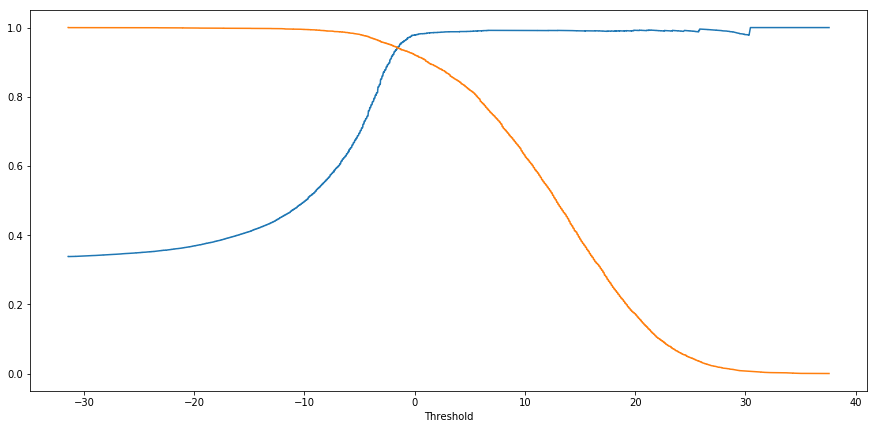

In [11]:
plt.figure(figsize=(15,7))
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])
plt.xlabel('Threshold')